In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

from torch import nn
import torch.nn.functional as F
from torch import optim
from sklearn.metrics import accuracy_score

import pandas as pd
import sys 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["figure.figsize"] = (8, 6)

CUDA is available!  Training on GPU ...


In [2]:
# df - train dataset
# sub - test dataset

df = pd.read_csv('C:/datasets/house-prices-advanced-regression-techniques/train.csv')
sub = pd.read_csv('C:/datasets/house-prices-advanced-regression-techniques/test.csv')

In [3]:
df = df.drop('Id',axis=1)
sub = sub.drop('Id',axis=1)

In [4]:
# let's check our features
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [5]:
# delete empty feature - MiscVal
df = df.drop('MiscFeature', axis=1)
sub = sub.drop('MiscFeature', axis=1)

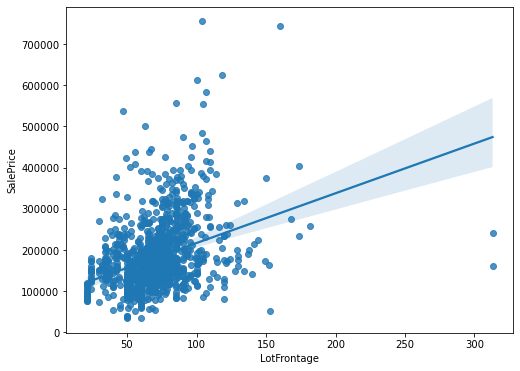

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

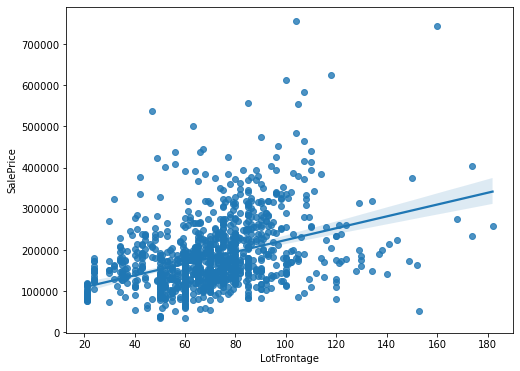

In [6]:
# get rid of abnormal outliers that makes noises to correlation
sns.regplot(data=df, x='LotFrontage', y='SalePrice')
plt.show()
# drop 2 data points from dataset
df = df.drop(df[df['LotFrontage'] > 300].index, axis=0)
sns.regplot(data=df, x='LotFrontage', y='SalePrice')

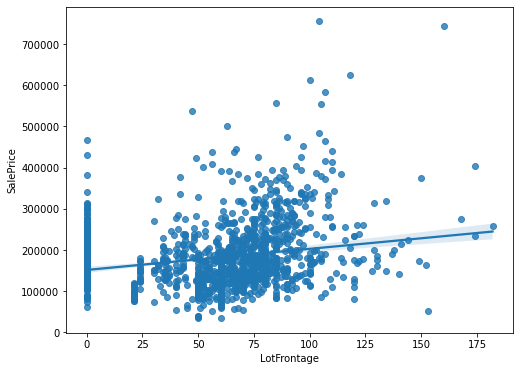

C:\Users\TimurRashitov\AppData\Local\Temp\ipykernel_6300\3892903727.py:90: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conc = pd.DataFrame(LotFrontage_filler['LotFrontage'].append(put_to['LotFrontage'],


<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

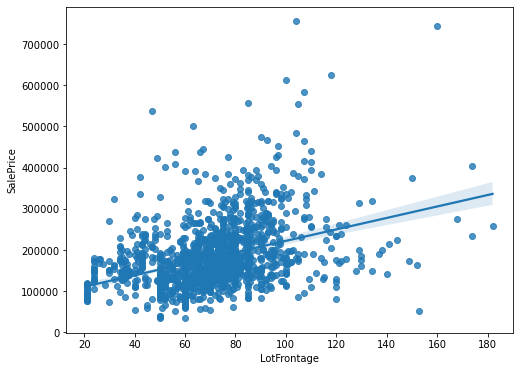

In [7]:
# filling empty information in LotFrontage with zeros and then implementing KNN imputation in order to approximate right correlation
df['LotFrontage'] = df['LotFrontage'].fillna(0)
sub['LotFrontage'] = sub['LotFrontage'].fillna(0)

sns.regplot(data=df, x='LotFrontage', y='SalePrice')
plt.show()

LotFrontage_filler = df.drop(list(df[df['LotFrontage'] == 0].index), axis=0)

LotFrontage_begin = df.drop(list(df[df['LotFrontage'] != 0].index), axis=0)

X_LotFrontage_final = LotFrontage_filler.drop('LotFrontage', axis=1)

y_LotFrontage_final = LotFrontage_filler['LotFrontage']

X_LotFrontage_to_insert = LotFrontage_begin.drop('LotFrontage', axis=1)

X_LotFrontage_final = pd.get_dummies(X_LotFrontage_final)
X_LotFrontage_to_insert_final = pd.get_dummies(X_LotFrontage_to_insert)

train_cols = X_LotFrontage_final.columns
test_cols = X_LotFrontage_to_insert_final.columns
common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)

X_LotFrontage_final = X_LotFrontage_final.drop(list(train_not_test),axis=1)

train_cols = X_LotFrontage_to_insert_final.columns
test_cols = X_LotFrontage_final.columns
common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)

X_LotFrontage_to_insert_final = X_LotFrontage_to_insert_final.drop(list(train_not_test),axis=1)

imp = SimpleImputer(missing_values=np.nan, strategy='median')

imp.fit(X_LotFrontage_final)

old_ind = X_LotFrontage_final.index

X_LotFrontage_final = imp.transform(X_LotFrontage_final)

X_LotFrontage_final = pd.DataFrame(X_LotFrontage_final)
featnam = list(imp.feature_names_in_)
for i in range(len(featnam)):
    X_LotFrontage_final = X_LotFrontage_final.rename(columns={i:featnam[i]})

X_LotFrontage_final['index1'] = old_ind
X_LotFrontage_final = X_LotFrontage_final.set_index('index1')

X_LotFrontage_final.index.name = None

old_ind = X_LotFrontage_to_insert_final.index
X_LotFrontage_to_insert_final= imp.transform(X_LotFrontage_to_insert_final)

X_LotFrontage_to_insert_final= pd.DataFrame(X_LotFrontage_to_insert_final)
featnam = list(imp.feature_names_in_)
for i in range(len(featnam)):
    X_LotFrontage_to_insert_final = X_LotFrontage_to_insert_final.rename(columns={i:featnam[i]})

X_LotFrontage_to_insert_final['index1'] = old_ind
X_LotFrontage_to_insert_final = X_LotFrontage_to_insert_final.set_index('index1')

X_LotFrontage_to_insert_final.index.name = None


X_LotFrontage_final = X_LotFrontage_final.drop('SalePrice', axis=1)
X_LotFrontage_to_insert_final = X_LotFrontage_to_insert_final.drop('SalePrice', axis=1)
X_LotFrontage_train, X_LotFrontage_test, y_LotFrontage_train, y_LotFrontage_test = train_test_split(X_LotFrontage_final, y_LotFrontage_final, test_size=0.2, random_state=17)

linreg = KNeighborsRegressor()
linreg.fit(X_LotFrontage_train, y_LotFrontage_train)

linreg.score(X_LotFrontage_test, y_LotFrontage_test)

# print(f"mean_absolute_error {mean_absolute_error(y_LotFrontage_test, linreg.predict(X_LotFrontage_test))}")
# print(f"mean_squared_error {mean_squared_error(y_LotFrontage_test, linreg.predict(X_LotFrontage_test))}")
# print(f"r2_score {r2_score(y_LotFrontage_test, linreg.predict(X_LotFrontage_test))}")

put_to = pd.DataFrame(linreg.predict(X_LotFrontage_to_insert_final))

put_to['index1'] = LotFrontage_begin.index
put_to = put_to.set_index('index1') 

put_to = put_to.rename(columns={0:'LotFrontage'})
put_to.index.name = None

LotFrontage_final = LotFrontage_begin.copy()

conc = pd.DataFrame(LotFrontage_filler['LotFrontage'].append(put_to['LotFrontage'], 
                  ignore_index = False),columns=['LotFrontage'])

conc = conc.sort_index(axis=0)

df['LotFrontage'] = conc['LotFrontage']

sns.regplot(data=df, x='LotFrontage', y='SalePrice')

C:\Users\TimurRashitov\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


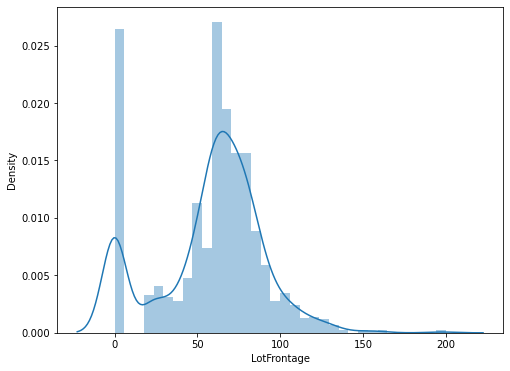

C:\Users\TimurRashitov\AppData\Local\Temp\ipykernel_6300\3336628820.py:86: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conc = pd.DataFrame(LotFrontage_filler['LotFrontage'].append(put_to['LotFrontage'],
C:\Users\TimurRashitov\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LotFrontage', ylabel='Density'>

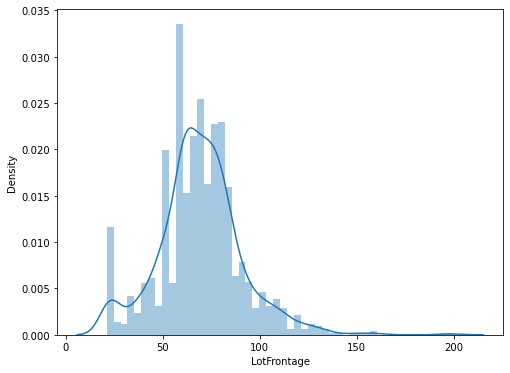

In [8]:
# same method with test dataset, we implement imputation and check distribution before and after

sns.distplot(sub['LotFrontage'])
plt.show()

LotFrontage_filler = sub.drop(list(sub[sub['LotFrontage'] == 0].index), axis=0)

LotFrontage_begin = sub.drop(list(sub[sub['LotFrontage'] != 0].index), axis=0)

X_LotFrontage_final = LotFrontage_filler.drop('LotFrontage', axis=1)

y_LotFrontage_final = LotFrontage_filler['LotFrontage']

X_LotFrontage_to_insert = LotFrontage_begin.drop('LotFrontage', axis=1)

X_LotFrontage_final = pd.get_dummies(X_LotFrontage_final)
X_LotFrontage_to_insert_final = pd.get_dummies(X_LotFrontage_to_insert)

train_cols = X_LotFrontage_final.columns
test_cols = X_LotFrontage_to_insert_final.columns
common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)

X_LotFrontage_final = X_LotFrontage_final.drop(list(train_not_test),axis=1)

train_cols = X_LotFrontage_to_insert_final.columns
test_cols = X_LotFrontage_final.columns
common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)

X_LotFrontage_to_insert_final = X_LotFrontage_to_insert_final.drop(list(train_not_test),axis=1)

imp = SimpleImputer(missing_values=np.nan, strategy='median')

imp.fit(X_LotFrontage_final)

old_ind = X_LotFrontage_final.index

X_LotFrontage_final = imp.transform(X_LotFrontage_final)

X_LotFrontage_final = pd.DataFrame(X_LotFrontage_final)
featnam = list(imp.feature_names_in_)
for i in range(len(featnam)):
    X_LotFrontage_final = X_LotFrontage_final.rename(columns={i:featnam[i]})

X_LotFrontage_final['index1'] = old_ind
X_LotFrontage_final = X_LotFrontage_final.set_index('index1')

X_LotFrontage_final.index.name = None

old_ind = X_LotFrontage_to_insert_final.index
X_LotFrontage_to_insert_final= imp.transform(X_LotFrontage_to_insert_final)

X_LotFrontage_to_insert_final= pd.DataFrame(X_LotFrontage_to_insert_final)
featnam = list(imp.feature_names_in_)
for i in range(len(featnam)):
    X_LotFrontage_to_insert_final = X_LotFrontage_to_insert_final.rename(columns={i:featnam[i]})

X_LotFrontage_to_insert_final['index1'] = old_ind
X_LotFrontage_to_insert_final = X_LotFrontage_to_insert_final.set_index('index1')

X_LotFrontage_to_insert_final.index.name = None


X_LotFrontage_train, X_LotFrontage_test, y_LotFrontage_train, y_LotFrontage_test = train_test_split(X_LotFrontage_final, y_LotFrontage_final, test_size=0.2, random_state=17)

linreg = KNeighborsRegressor()
linreg.fit(X_LotFrontage_train, y_LotFrontage_train)

linreg.score(X_LotFrontage_test, y_LotFrontage_test)

# print(f"mean_absolute_error {mean_absolute_error(y_LotFrontage_test, linreg.predict(X_LotFrontage_test))}")
# print(f"mean_squared_error {mean_squared_error(y_LotFrontage_test, linreg.predict(X_LotFrontage_test))}")
# print(f"r2_score {r2_score(y_LotFrontage_test, linreg.predict(X_LotFrontage_test))}")

put_to = pd.DataFrame(linreg.predict(X_LotFrontage_to_insert_final))

put_to['index1'] = LotFrontage_begin.index
put_to = put_to.set_index('index1') 

put_to = put_to.rename(columns={0:'LotFrontage'})
put_to.index.name = None

LotFrontage_final = LotFrontage_begin.copy()

conc = pd.DataFrame(LotFrontage_filler['LotFrontage'].append(put_to['LotFrontage'], 
                  ignore_index = False),columns=['LotFrontage'])

conc = conc.sort_index(axis=0)

sub['LotFrontage'] = conc['LotFrontage']

sns.distplot(sub['LotFrontage'])

In [9]:
# formatting dtypes for datasets
df_types = pd.DataFrame(df.drop(['SalePrice'],axis=1).dtypes).reset_index().rename(columns={'index':'columns', 0:'dtypes'})
df_types['dtypes'] = df_types['dtypes'].astype(str)
sub_types = pd.DataFrame(sub.dtypes).reset_index().rename(columns={'index':'columns', 0:'dtypes'})
sub_types['dtypes'] = sub_types['dtypes'].astype(str)
lst_of_diff_types = []
for i in range(df_types.shape[0]):
    if list(df_types.iloc[i].values) != list(sub_types.iloc[i].values):
        lst_of_diff_types.append(df_types.iloc[i].values[0]) 
df[lst_of_diff_types] = df[lst_of_diff_types].astype(np.float64)
print(lst_of_diff_types)

['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']


In [10]:
# comparing if some object features are not the same for both datasets
df_types = pd.DataFrame(df.drop('SalePrice',axis=1).dtypes).reset_index().rename(columns={'index':'columns', 0:'dtypes'})
df_types['dtypes'] = df_types['dtypes'].astype(str)
sub_types = pd.DataFrame(sub.dtypes).reset_index().rename(columns={'index':'columns', 0:'dtypes'})
sub_types['dtypes'] = sub_types['dtypes'].astype(str)
count = 0
for i in range(0,df_types[df_types['dtypes'] == 'object']['columns'].shape[0]):
    if df_types[df_types['dtypes'] == 'object']['columns'].iloc[i] != sub_types[sub_types['dtypes'] == 'object']['columns'].iloc[i]:
        count = +1
if df_types[df_types['dtypes'] == 'object']['columns'].shape[0] == sub_types[sub_types['dtypes'] == 'object']['columns'].shape[0] and count == 0:
    print('all object columns are the same')

all object columns are the same


In [11]:
# checking difference in values between two datasets by comparing two sets of values of each column
dic = dict()
for col in df_types[df_types['dtypes'] == 'object']['columns'].tolist():
    dic[col] = str(set(sub[col].unique().tolist()) - set(df[col].unique().tolist()))
# we found only NaN values, so we have to SimpleImpute all categorical data

In [12]:
for key, value in dic.items():
    if value == '{nan}':
        print(key, value)

MSZoning {nan}
Utilities {nan}
Exterior1st {nan}
Exterior2nd {nan}
KitchenQual {nan}
Functional {nan}
SaleType {nan}


In [13]:
# filling missing values with No category, according to description of dataset NaN values of these columns are meant to be No Category
df['Alley'] = df['Alley'].fillna('NoAll')
sub['Alley'] = sub['Alley'].fillna('NoAll')
df['FireplaceQu'] = df['FireplaceQu'].fillna('NoFire')
sub['FireplaceQu'] = sub['FireplaceQu'].fillna('NoFire')
df['PoolQC'] = df['PoolQC'].fillna('NoPool')
sub['PoolQC'] = sub['PoolQC'].fillna('NoPool')
df['Fence'] = df['Fence'].fillna('NoFence')
sub['Fence'] = sub['Fence'].fillna('NoFence')
df['MasVnrType'] = df['MasVnrType'].fillna('None')
sub['MasVnrType'] = sub['MasVnrType'].fillna('None')
df['BsmtQual'] = df['BsmtQual'].fillna('None')
sub['BsmtQual'] = sub['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
sub['BsmtCond'] = sub['BsmtCond'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
sub['BsmtExposure'] = sub['BsmtExposure'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
sub['BsmtFinType1'] = sub['BsmtFinType1'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')
sub['BsmtFinType2'] = sub['BsmtFinType2'].fillna('None')
df['GarageType'] = df['GarageType'].fillna('None')
sub['GarageType'] = sub['GarageType'].fillna('None')
df['GarageFinish'] = df['GarageFinish'].fillna('None')
sub['GarageFinish'] = sub['GarageFinish'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
sub['GarageQual'] = sub['GarageQual'].fillna('None')
df['GarageCond'] = df['GarageCond'].fillna('None')
sub['GarageCond'] = sub['GarageCond'].fillna('None')

df = df.drop(df[df['Electrical'].isna() == True].index, axis=0)

In [14]:
list_of_categorical_columns = df.dtypes[(df.dtypes) == 'object'].index.tolist()
list_of_numerical_columns = df.dtypes[(df.dtypes) != 'object'].index.tolist()

In [15]:
# checking NaNs of categories DF
df[df.dtypes[(df.dtypes) == 'object'].index.tolist()].isna().sum()

MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
SaleType         0
SaleCondition    0
dtype: int64

In [16]:
# imputation of insignifficant nans in sub 
for col in (sub.dtypes[sub.isna().sum()[sub.isna().sum() > 0].index][sub.dtypes[sub.isna().sum()[sub.isna().sum() > 0].index] == 'object']).index:
    sub[col] = sub[col].fillna(list(sub[col].mode())[0])

In [17]:
# checking NaNs of categories in sub
sub[sub.dtypes[(sub.dtypes) == 'object'].index.tolist()].isna().sum()

MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
SaleType         0
SaleCondition    0
dtype: int64

In [18]:
from sklearn.preprocessing import OneHotEncoder
# OneHotEncoding categorical data to get rid of text info for TRAIN DATA
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[list_of_categorical_columns])
transformed = pd.DataFrame(transformed.toarray())

for i in range(0,transformed.shape[1]):
    transformed = transformed.rename(columns={i:((ohe.get_feature_names_out())[i])})
df = df.reset_index()
df = df.drop(list_of_categorical_columns, axis=1)
for col in transformed.columns:
    df[col] = transformed[col].copy() 
df = df.drop('index', axis=1)

C:\Users\TimurRashitov\AppData\Local\Temp\ipykernel_6300\3659407431.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = transformed[col].copy()
C:\Users\TimurRashitov\AppData\Local\Temp\ipykernel_6300\3659407431.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = transformed[col].copy()
C:\Users\TimurRashitov\AppData\Local\Temp\ipykernel_6300\3659407431.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

In [19]:
df.isna().sum()[df.isna().sum() > 0]

MasVnrArea      8
GarageYrBlt    81
dtype: int64

In [20]:
# OneHotEncoding categorical data to get rid of text info for TEST DATA
transformed = ohe.transform(sub[list_of_categorical_columns])
transformed = pd.DataFrame(transformed.toarray())

for i in range(0,transformed.shape[1]):
    transformed = transformed.rename(columns={i:((ohe.get_feature_names_out())[i])})
    
sub = sub.reset_index()

sub = sub.drop(list_of_categorical_columns, axis=1)

for col in transformed.columns:
    sub[col] = transformed[col].copy() 

sub = sub.drop('index', axis=1)

C:\Users\TimurRashitov\AppData\Local\Temp\ipykernel_6300\2144171061.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub[col] = transformed[col].copy()
C:\Users\TimurRashitov\AppData\Local\Temp\ipykernel_6300\2144171061.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub[col] = transformed[col].copy()
C:\Users\TimurRashitov\AppData\Local\Temp\ipykernel_6300\2144171061.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

In [21]:
# imputing insignifficant amount of NaN values with median values
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
sub['MasVnrArea'] = sub['MasVnrArea'].fillna(sub['MasVnrArea'].median())

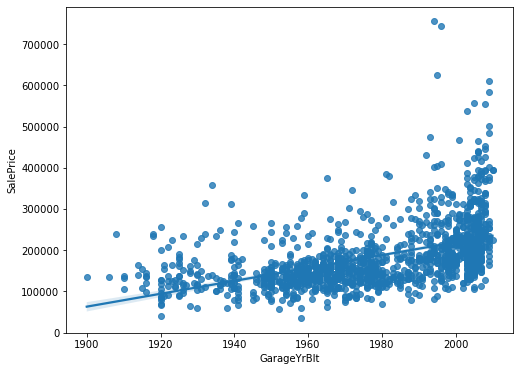

mean_absolute_error 15.482608695652177
mean_squared_error 436.1817391304346
r2_score 0.2820435174810798


C:\Users\TimurRashitov\AppData\Local\Temp\ipykernel_6300\2612799288.py:88: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conc = pd.DataFrame(GarageYrBlt_filler['GarageYrBlt'].append(put_to['GarageYrBlt'],


<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

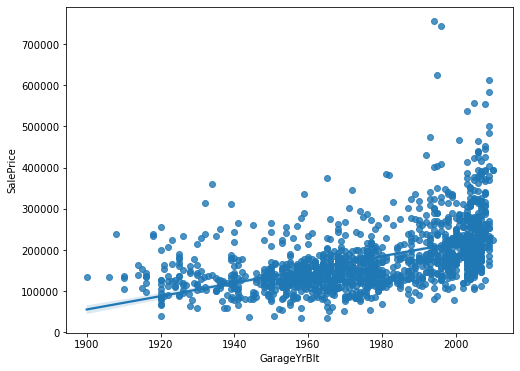

In [22]:
# Regression Imputation on df['GarageYrBlt']
sns.regplot(data=df, x='GarageYrBlt', y='SalePrice')
plt.show()

df['GarageYrBlt'] = df['GarageYrBlt'].fillna(-537)
GarageYrBlt_filler = df.drop(list(df[df['GarageYrBlt'] == (-537)].index), axis=0)

GarageYrBlt_begin = df.drop(list(df[df['GarageYrBlt'] != (-537)].index), axis=0)

X_GarageYrBlt_final = GarageYrBlt_filler.drop('GarageYrBlt', axis=1)

y_GarageYrBlt_final = GarageYrBlt_filler['GarageYrBlt']

X_GarageYrBlt_to_insert = GarageYrBlt_begin.drop('GarageYrBlt', axis=1)

X_GarageYrBlt_final = pd.get_dummies(X_GarageYrBlt_final)
X_GarageYrBlt_to_insert_final = pd.get_dummies(X_GarageYrBlt_to_insert)

train_cols = X_GarageYrBlt_final.columns
test_cols = X_GarageYrBlt_to_insert_final.columns
common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)

X_GarageYrBlt_final = X_GarageYrBlt_final.drop(list(train_not_test),axis=1)

train_cols = X_GarageYrBlt_to_insert_final.columns
test_cols = X_GarageYrBlt_final.columns
common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)

X_GarageYrBlt_to_insert_final = X_GarageYrBlt_to_insert_final.drop(list(train_not_test),axis=1)

imp = SimpleImputer(missing_values=np.nan, strategy='median')

imp.fit(X_GarageYrBlt_final)

old_ind = X_GarageYrBlt_final.index

X_GarageYrBlt_final = imp.transform(X_GarageYrBlt_final)

X_GarageYrBlt_final = pd.DataFrame(X_GarageYrBlt_final)
featnam = list(imp.feature_names_in_)
for i in range(len(featnam)):
    X_GarageYrBlt_final = X_GarageYrBlt_final.rename(columns={i:featnam[i]})

X_GarageYrBlt_final['index1'] = old_ind
X_GarageYrBlt_final = X_GarageYrBlt_final.set_index('index1')

X_GarageYrBlt_final.index.name = None

old_ind = X_GarageYrBlt_to_insert_final.index
X_GarageYrBlt_to_insert_final= imp.transform(X_GarageYrBlt_to_insert_final)

X_GarageYrBlt_to_insert_final= pd.DataFrame(X_GarageYrBlt_to_insert_final)
featnam = list(imp.feature_names_in_)
for i in range(len(featnam)):
    X_GarageYrBlt_to_insert_final = X_GarageYrBlt_to_insert_final.rename(columns={i:featnam[i]})

X_GarageYrBlt_to_insert_final['index1'] = old_ind
X_GarageYrBlt_to_insert_final = X_GarageYrBlt_to_insert_final.set_index('index1')

X_GarageYrBlt_to_insert_final.index.name = None


X_GarageYrBlt_final = X_GarageYrBlt_final.drop('SalePrice', axis=1)
X_GarageYrBlt_to_insert_final = X_GarageYrBlt_to_insert_final.drop('SalePrice', axis=1)
X_GarageYrBlt_train, X_GarageYrBlt_test, y_GarageYrBlt_train, y_GarageYrBlt_test = train_test_split(X_GarageYrBlt_final, y_GarageYrBlt_final, test_size=0.2, random_state=17)

linreg = KNeighborsRegressor()
linreg.fit(X_GarageYrBlt_train, y_GarageYrBlt_train)

linreg.score(X_GarageYrBlt_test, y_GarageYrBlt_test)

print(f"mean_absolute_error {mean_absolute_error(y_GarageYrBlt_test, linreg.predict(X_GarageYrBlt_test))}")
print(f"mean_squared_error {mean_squared_error(y_GarageYrBlt_test, linreg.predict(X_GarageYrBlt_test))}")
print(f"r2_score {r2_score(y_GarageYrBlt_test, linreg.predict(X_GarageYrBlt_test))}")

put_to = pd.DataFrame(linreg.predict(X_GarageYrBlt_to_insert_final))

put_to['index1'] = GarageYrBlt_begin.index
put_to = put_to.set_index('index1') 

put_to = put_to.rename(columns={0:'GarageYrBlt'})
put_to.index.name = None

GarageYrBlt_final = GarageYrBlt_begin.copy()

conc = pd.DataFrame(GarageYrBlt_filler['GarageYrBlt'].append(put_to['GarageYrBlt'], 
                  ignore_index = False),columns=['GarageYrBlt'])

conc = conc.sort_index(axis=0)

df['GarageYrBlt'] = conc['GarageYrBlt']

sns.regplot(data=df, x='GarageYrBlt', y='SalePrice')

C:\Users\TimurRashitov\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


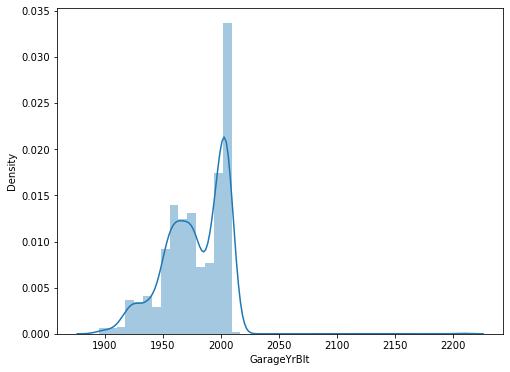

mean_absolute_error 16.412274368231053
mean_squared_error 477.9296750902529
r2_score 0.32730816769795046


C:\Users\TimurRashitov\AppData\Local\Temp\ipykernel_6300\3144814634.py:84: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conc = pd.DataFrame(GarageYrBlt_filler['GarageYrBlt'].append(put_to['GarageYrBlt'],
C:\Users\TimurRashitov\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GarageYrBlt', ylabel='Density'>

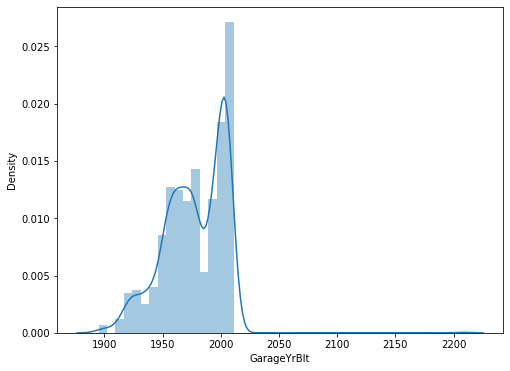

In [23]:
sns.distplot(sub['GarageYrBlt'])
plt.show()

sub['GarageYrBlt'] = sub['GarageYrBlt'].fillna(-537)
GarageYrBlt_filler = sub.drop(list(sub[sub['GarageYrBlt'] == (-537)].index), axis=0)

GarageYrBlt_begin = sub.drop(list(sub[sub['GarageYrBlt'] != (-537)].index), axis=0)

X_GarageYrBlt_final = GarageYrBlt_filler.drop('GarageYrBlt', axis=1)

y_GarageYrBlt_final = GarageYrBlt_filler['GarageYrBlt']

X_GarageYrBlt_to_insert = GarageYrBlt_begin.drop('GarageYrBlt', axis=1)

X_GarageYrBlt_final = pd.get_dummies(X_GarageYrBlt_final)
X_GarageYrBlt_to_insert_final = pd.get_dummies(X_GarageYrBlt_to_insert)

train_cols = X_GarageYrBlt_final.columns
test_cols = X_GarageYrBlt_to_insert_final.columns
common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)

X_GarageYrBlt_final = X_GarageYrBlt_final.drop(list(train_not_test),axis=1)

train_cols = X_GarageYrBlt_to_insert_final.columns
test_cols = X_GarageYrBlt_final.columns
common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)

X_GarageYrBlt_to_insert_final = X_GarageYrBlt_to_insert_final.drop(list(train_not_test),axis=1)

imp = SimpleImputer(missing_values=np.nan, strategy='median')

imp.fit(X_GarageYrBlt_final)

old_ind = X_GarageYrBlt_final.index

X_GarageYrBlt_final = imp.transform(X_GarageYrBlt_final)

X_GarageYrBlt_final = pd.DataFrame(X_GarageYrBlt_final)
featnam = list(imp.feature_names_in_)
for i in range(len(featnam)):
    X_GarageYrBlt_final = X_GarageYrBlt_final.rename(columns={i:featnam[i]})

X_GarageYrBlt_final['index1'] = old_ind
X_GarageYrBlt_final = X_GarageYrBlt_final.set_index('index1')

X_GarageYrBlt_final.index.name = None

old_ind = X_GarageYrBlt_to_insert_final.index
X_GarageYrBlt_to_insert_final= imp.transform(X_GarageYrBlt_to_insert_final)

X_GarageYrBlt_to_insert_final= pd.DataFrame(X_GarageYrBlt_to_insert_final)
featnam = list(imp.feature_names_in_)
for i in range(len(featnam)):
    X_GarageYrBlt_to_insert_final = X_GarageYrBlt_to_insert_final.rename(columns={i:featnam[i]})

X_GarageYrBlt_to_insert_final['index1'] = old_ind
X_GarageYrBlt_to_insert_final = X_GarageYrBlt_to_insert_final.set_index('index1')

X_GarageYrBlt_to_insert_final.index.name = None

X_GarageYrBlt_train, X_GarageYrBlt_test, y_GarageYrBlt_train, y_GarageYrBlt_test = train_test_split(X_GarageYrBlt_final, y_GarageYrBlt_final, test_size=0.2, random_state=17)

linreg = KNeighborsRegressor()
linreg.fit(X_GarageYrBlt_train, y_GarageYrBlt_train)

linreg.score(X_GarageYrBlt_test, y_GarageYrBlt_test)

print(f"mean_absolute_error {mean_absolute_error(y_GarageYrBlt_test, linreg.predict(X_GarageYrBlt_test))}")
print(f"mean_squared_error {mean_squared_error(y_GarageYrBlt_test, linreg.predict(X_GarageYrBlt_test))}")
print(f"r2_score {r2_score(y_GarageYrBlt_test, linreg.predict(X_GarageYrBlt_test))}")

put_to = pd.DataFrame(linreg.predict(X_GarageYrBlt_to_insert_final))

put_to['index1'] = GarageYrBlt_begin.index
put_to = put_to.set_index('index1') 

put_to = put_to.rename(columns={0:'GarageYrBlt'})
put_to.index.name = None

GarageYrBlt_final = GarageYrBlt_begin.copy()

conc = pd.DataFrame(GarageYrBlt_filler['GarageYrBlt'].append(put_to['GarageYrBlt'], 
                  ignore_index = False),columns=['GarageYrBlt'])

conc = conc.sort_index(axis=0)

sub['GarageYrBlt'] = conc['GarageYrBlt']

sns.distplot(sub['GarageYrBlt'])

In [24]:
sub.isna().sum()[sub.isna().sum() > 0]

BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
GarageCars      1
GarageArea      1
dtype: int64

In [25]:
# imputation with median for single missing values
for col in (sub.dtypes[sub.isna().sum()[sub.isna().sum() > 0].index][sub.dtypes[sub.isna().sum()[sub.isna().sum() > 0].index] == 'float64']).index:
    sub[col] = sub[col].fillna(sub[col].median())

In [26]:
# finally see no missing values
sub.isna().sum()[sub.isna().sum() > 0]

Series([], dtype: int64)

In [27]:
y = df['SalePrice']
df = df.drop('SalePrice', axis=1)

In [28]:
df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,60,62.0,7917,6,5,1999,2000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1453,20,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1454,70,66.0,9042,7,9,1941,2006,0.0,275.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1455,20,68.0,9717,5,6,1950,1996,0.0,49.0,1029.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
# Log Transformation of Target variable
y = np.log1p(y)

In [30]:
y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1452    12.072547
1453    12.254868
1454    12.493133
1455    11.864469
1456    11.901590
Name: SalePrice, Length: 1457, dtype: float64

In [31]:
sub

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1455,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1456,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1457,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
df_rescaled = scaler.transform(df)
sub_rescaled = scaler.transform(sub)

In [45]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(df)
# df_rescaled = scaler.transform(df)
# sub_rescaled = scaler.transform(sub)

In [46]:
from sklearn.model_selection import KFold
kfold= KFold(n_splits=10,random_state=42,shuffle=True) #kfold cross validation, 10-subsets
X_train, X_test, y_train, y_test = train_test_split(df_rescaled, y, test_size=0.2,random_state=17)

In [47]:
X_train = torch.tensor(X_train).float(); X_train.shape

torch.Size([1165, 296])

In [48]:
y_train = torch.tensor(y_train.to_numpy()).view(-1,1).float(); y_train.shape

torch.Size([1165, 1])

In [49]:
X_test = torch.tensor(X_test).float(); X_test.shape

torch.Size([292, 296])

In [50]:
y_test = torch.tensor(y_test.to_numpy()).view(-1,1).float(); y_test.shape

torch.Size([292, 1])

In [51]:
model = nn.Sequential(nn.Linear(296,512),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(512,128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128,1)
                      ).cuda()
criterion = nn.MSELoss()

In [52]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [53]:
# model.load_state_dict(torch.load('model_house.pt'))
model.eval()
print(f"mean_absolute_error {mean_absolute_error(y_test, model(X_test.cuda()).cpu().data.numpy())}")
print(f"root_mean_squared_error {mean_squared_error(y_test, model(X_test.cuda()).cpu().data.numpy(), squared=False)}")
print(f"r2_score {r2_score(y_test,model(X_test.cuda()).cpu().data.numpy())}")

mean_absolute_error 12.064952850341797
root_mean_squared_error 12.071014404296875
r2_score -943.9034017942101


In [54]:
valid_metric_min = np.Inf
epochs=1000
for e in range(epochs):
    model.train()
    counter = 0
    train_loss = 0.0
    valid_loss = 0.0
    for i in range(0,37):
        if counter != 1152:
            counter += 32
            X_batch = X_train[counter-32:counter].cuda()
            y_batch = y_train[counter-32:counter].view(-1,1).cuda()

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        elif counter == 1152:
            counter += 13
            X_batch = X_train[counter-13:counter].cuda()
            y_batch = y_train[counter-13:counter].view(-1,1).cuda()

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    model.eval()
    train_loss = train_loss
    valid_loss = criterion(model(X_test.cuda()), y_test.cuda())
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    e, train_loss, valid_loss))
    valid_metric = mean_squared_error(y_test, model(X_test.cuda()).cpu().data.numpy(), squared=False)
    if valid_metric <= valid_metric_min:
        print('Validation metrics decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_metric_min,valid_metric))
        torch.save(model.state_dict(), 'model_house.pt')
        valid_metric_min = valid_metric

Epoch: 0 	Training Loss: 1239.528445 	Validation Loss: 5.402724
Validation metrics decreased (inf --> 2.324376).  Saving model ...
Epoch: 1 	Training Loss: 161.936632 	Validation Loss: 2.980903
Validation metrics decreased (2.324376 --> 1.726529).  Saving model ...
Epoch: 2 	Training Loss: 103.353795 	Validation Loss: 1.720996
Validation metrics decreased (1.726529 --> 1.311867).  Saving model ...
Epoch: 3 	Training Loss: 98.302581 	Validation Loss: 3.801457
Epoch: 4 	Training Loss: 139.568073 	Validation Loss: 6.639789
Epoch: 5 	Training Loss: 155.263357 	Validation Loss: 2.200676
Epoch: 6 	Training Loss: 106.581868 	Validation Loss: 3.989024
Epoch: 7 	Training Loss: 74.727270 	Validation Loss: 2.282473
Epoch: 8 	Training Loss: 46.291365 	Validation Loss: 1.305988
Validation metrics decreased (1.311867 --> 1.142798).  Saving model ...
Epoch: 9 	Training Loss: 32.976931 	Validation Loss: 1.103749
Validation metrics decreased (1.142798 --> 1.050594).  Saving model ...
Epoch: 10 	Trainin

Epoch: 103 	Training Loss: 4.204654 	Validation Loss: 0.341310
Epoch: 104 	Training Loss: 4.694139 	Validation Loss: 0.337597
Validation metrics decreased (0.583784 --> 0.581031).  Saving model ...
Epoch: 105 	Training Loss: 4.661943 	Validation Loss: 0.369919
Epoch: 106 	Training Loss: 4.401599 	Validation Loss: 0.356711
Epoch: 107 	Training Loss: 4.374880 	Validation Loss: 0.333178
Validation metrics decreased (0.581031 --> 0.577216).  Saving model ...
Epoch: 108 	Training Loss: 4.097963 	Validation Loss: 0.337761
Epoch: 109 	Training Loss: 4.744371 	Validation Loss: 0.324113
Validation metrics decreased (0.577216 --> 0.569309).  Saving model ...
Epoch: 110 	Training Loss: 4.243740 	Validation Loss: 0.318466
Validation metrics decreased (0.569309 --> 0.564328).  Saving model ...
Epoch: 111 	Training Loss: 4.189649 	Validation Loss: 0.323396
Epoch: 112 	Training Loss: 4.203661 	Validation Loss: 0.303524
Validation metrics decreased (0.564328 --> 0.550930).  Saving model ...
Epoch: 113

Epoch: 199 	Training Loss: 2.433744 	Validation Loss: 0.180800
Epoch: 200 	Training Loss: 2.586764 	Validation Loss: 0.169244
Validation metrics decreased (0.415465 --> 0.411393).  Saving model ...
Epoch: 201 	Training Loss: 2.428964 	Validation Loss: 0.166992
Validation metrics decreased (0.411393 --> 0.408647).  Saving model ...
Epoch: 202 	Training Loss: 2.359124 	Validation Loss: 0.167246
Epoch: 203 	Training Loss: 2.385145 	Validation Loss: 0.174609
Epoch: 204 	Training Loss: 2.553796 	Validation Loss: 0.162847
Validation metrics decreased (0.408647 --> 0.403543).  Saving model ...
Epoch: 205 	Training Loss: 2.185942 	Validation Loss: 0.169706
Epoch: 206 	Training Loss: 2.447389 	Validation Loss: 0.162383
Validation metrics decreased (0.403543 --> 0.402968).  Saving model ...
Epoch: 207 	Training Loss: 2.548706 	Validation Loss: 0.160816
Validation metrics decreased (0.402968 --> 0.401019).  Saving model ...
Epoch: 208 	Training Loss: 2.501917 	Validation Loss: 0.157448
Validation

Epoch: 293 	Training Loss: 1.702643 	Validation Loss: 0.105825
Validation metrics decreased (0.327497 --> 0.325307).  Saving model ...
Epoch: 294 	Training Loss: 1.650228 	Validation Loss: 0.108995
Epoch: 295 	Training Loss: 1.481831 	Validation Loss: 0.112061
Epoch: 296 	Training Loss: 1.624152 	Validation Loss: 0.110533
Epoch: 297 	Training Loss: 1.524759 	Validation Loss: 0.107690
Epoch: 298 	Training Loss: 1.639413 	Validation Loss: 0.109580
Epoch: 299 	Training Loss: 1.525761 	Validation Loss: 0.112302
Epoch: 300 	Training Loss: 1.625654 	Validation Loss: 0.109931
Epoch: 301 	Training Loss: 1.562296 	Validation Loss: 0.107407
Epoch: 302 	Training Loss: 1.394570 	Validation Loss: 0.107534
Epoch: 303 	Training Loss: 1.492254 	Validation Loss: 0.103466
Validation metrics decreased (0.325307 --> 0.321662).  Saving model ...
Epoch: 304 	Training Loss: 1.520668 	Validation Loss: 0.103258
Validation metrics decreased (0.321662 --> 0.321338).  Saving model ...
Epoch: 305 	Training Loss: 1

Epoch: 389 	Training Loss: 1.064172 	Validation Loss: 0.081934
Validation metrics decreased (0.287894 --> 0.286241).  Saving model ...
Epoch: 390 	Training Loss: 1.010428 	Validation Loss: 0.082629
Epoch: 391 	Training Loss: 1.104953 	Validation Loss: 0.086016
Epoch: 392 	Training Loss: 1.101740 	Validation Loss: 0.080924
Validation metrics decreased (0.286241 --> 0.284472).  Saving model ...
Epoch: 393 	Training Loss: 1.021636 	Validation Loss: 0.080279
Validation metrics decreased (0.284472 --> 0.283336).  Saving model ...
Epoch: 394 	Training Loss: 0.985471 	Validation Loss: 0.082152
Epoch: 395 	Training Loss: 1.076093 	Validation Loss: 0.081150
Epoch: 396 	Training Loss: 1.080393 	Validation Loss: 0.084948
Epoch: 397 	Training Loss: 0.995291 	Validation Loss: 0.079119
Validation metrics decreased (0.283336 --> 0.281281).  Saving model ...
Epoch: 398 	Training Loss: 0.978927 	Validation Loss: 0.082625
Epoch: 399 	Training Loss: 1.020899 	Validation Loss: 0.079393
Epoch: 400 	Trainin

Epoch: 482 	Training Loss: 0.801271 	Validation Loss: 0.064700
Epoch: 483 	Training Loss: 0.764094 	Validation Loss: 0.065197
Epoch: 484 	Training Loss: 0.745085 	Validation Loss: 0.065516
Epoch: 485 	Training Loss: 0.753907 	Validation Loss: 0.063467
Validation metrics decreased (0.253732 --> 0.251927).  Saving model ...
Epoch: 486 	Training Loss: 0.728750 	Validation Loss: 0.063476
Epoch: 487 	Training Loss: 0.735613 	Validation Loss: 0.065821
Epoch: 488 	Training Loss: 0.763244 	Validation Loss: 0.064375
Epoch: 489 	Training Loss: 0.681585 	Validation Loss: 0.063742
Epoch: 490 	Training Loss: 0.708596 	Validation Loss: 0.065891
Epoch: 491 	Training Loss: 0.668689 	Validation Loss: 0.063066
Validation metrics decreased (0.251927 --> 0.251130).  Saving model ...
Epoch: 492 	Training Loss: 0.745489 	Validation Loss: 0.063173
Epoch: 493 	Training Loss: 0.723838 	Validation Loss: 0.063927
Epoch: 494 	Training Loss: 0.812695 	Validation Loss: 0.066655
Epoch: 495 	Training Loss: 0.752737 	

Epoch: 582 	Training Loss: 0.602271 	Validation Loss: 0.054530
Epoch: 583 	Training Loss: 0.582813 	Validation Loss: 0.051571
Validation metrics decreased (0.227773 --> 0.227091).  Saving model ...
Epoch: 584 	Training Loss: 0.582933 	Validation Loss: 0.051768
Epoch: 585 	Training Loss: 0.572081 	Validation Loss: 0.051468
Validation metrics decreased (0.227091 --> 0.226865).  Saving model ...
Epoch: 586 	Training Loss: 0.532709 	Validation Loss: 0.051773
Epoch: 587 	Training Loss: 0.560033 	Validation Loss: 0.052157
Epoch: 588 	Training Loss: 0.571357 	Validation Loss: 0.051459
Validation metrics decreased (0.226865 --> 0.226845).  Saving model ...
Epoch: 589 	Training Loss: 0.583715 	Validation Loss: 0.051682
Epoch: 590 	Training Loss: 0.561621 	Validation Loss: 0.052316
Epoch: 591 	Training Loss: 0.520262 	Validation Loss: 0.051176
Validation metrics decreased (0.226845 --> 0.226221).  Saving model ...
Epoch: 592 	Training Loss: 0.554947 	Validation Loss: 0.051110
Validation metrics 

Epoch: 678 	Training Loss: 0.441792 	Validation Loss: 0.044713
Epoch: 679 	Training Loss: 0.441016 	Validation Loss: 0.044391
Epoch: 680 	Training Loss: 0.463887 	Validation Loss: 0.044572
Epoch: 681 	Training Loss: 0.456074 	Validation Loss: 0.044362
Epoch: 682 	Training Loss: 0.436415 	Validation Loss: 0.044415
Epoch: 683 	Training Loss: 0.454614 	Validation Loss: 0.044700
Epoch: 684 	Training Loss: 0.413088 	Validation Loss: 0.044147
Validation metrics decreased (0.210229 --> 0.210112).  Saving model ...
Epoch: 685 	Training Loss: 0.467817 	Validation Loss: 0.044218
Epoch: 686 	Training Loss: 0.455273 	Validation Loss: 0.043776
Validation metrics decreased (0.210112 --> 0.209228).  Saving model ...
Epoch: 687 	Training Loss: 0.441849 	Validation Loss: 0.044331
Epoch: 688 	Training Loss: 0.471996 	Validation Loss: 0.044081
Epoch: 689 	Training Loss: 0.406149 	Validation Loss: 0.044095
Epoch: 690 	Training Loss: 0.409367 	Validation Loss: 0.043674
Validation metrics decreased (0.20922

Epoch: 786 	Training Loss: 0.379561 	Validation Loss: 0.038490
Validation metrics decreased (0.196291 --> 0.196189).  Saving model ...
Epoch: 787 	Training Loss: 0.388441 	Validation Loss: 0.039746
Epoch: 788 	Training Loss: 0.384135 	Validation Loss: 0.038800
Epoch: 789 	Training Loss: 0.368866 	Validation Loss: 0.039364
Epoch: 790 	Training Loss: 0.362652 	Validation Loss: 0.039121
Epoch: 791 	Training Loss: 0.365829 	Validation Loss: 0.039675
Epoch: 792 	Training Loss: 0.390289 	Validation Loss: 0.038751
Epoch: 793 	Training Loss: 0.373632 	Validation Loss: 0.040008
Epoch: 794 	Training Loss: 0.405926 	Validation Loss: 0.038753
Epoch: 795 	Training Loss: 0.363715 	Validation Loss: 0.038230
Validation metrics decreased (0.196189 --> 0.195526).  Saving model ...
Epoch: 796 	Training Loss: 0.335442 	Validation Loss: 0.038063
Validation metrics decreased (0.195526 --> 0.195096).  Saving model ...
Epoch: 797 	Training Loss: 0.378022 	Validation Loss: 0.039084
Epoch: 798 	Training Loss: 0

Epoch: 891 	Training Loss: 0.310813 	Validation Loss: 0.035383
Epoch: 892 	Training Loss: 0.338015 	Validation Loss: 0.035043
Epoch: 893 	Training Loss: 0.306429 	Validation Loss: 0.034975
Epoch: 894 	Training Loss: 0.310590 	Validation Loss: 0.035423
Epoch: 895 	Training Loss: 0.318701 	Validation Loss: 0.034907
Validation metrics decreased (0.186918 --> 0.186835).  Saving model ...
Epoch: 896 	Training Loss: 0.320225 	Validation Loss: 0.035132
Epoch: 897 	Training Loss: 0.321509 	Validation Loss: 0.035517
Epoch: 898 	Training Loss: 0.307453 	Validation Loss: 0.034746
Validation metrics decreased (0.186835 --> 0.186402).  Saving model ...
Epoch: 899 	Training Loss: 0.325238 	Validation Loss: 0.035136
Epoch: 900 	Training Loss: 0.301477 	Validation Loss: 0.034514
Validation metrics decreased (0.186402 --> 0.185778).  Saving model ...
Epoch: 901 	Training Loss: 0.322920 	Validation Loss: 0.034386
Validation metrics decreased (0.185778 --> 0.185436).  Saving model ...
Epoch: 902 	Trainin

Epoch: 996 	Training Loss: 0.267467 	Validation Loss: 0.032496
Epoch: 997 	Training Loss: 0.279878 	Validation Loss: 0.031904
Validation metrics decreased (0.178725 --> 0.178617).  Saving model ...
Epoch: 998 	Training Loss: 0.284914 	Validation Loss: 0.032466
Epoch: 999 	Training Loss: 0.292289 	Validation Loss: 0.032289


In [55]:
# write submission results for Kaggle
model.load_state_dict(torch.load('model_house.pt'))
predictions = np.expm1(model(torch.tensor(sub_rescaled).float().cuda()).cpu().data.numpy())

In [56]:
submission = pd.read_csv('C:/datasets/house-prices-advanced-regression-techniques/sample_submission.csv')

submission['SalePrice'] = predictions

submission.to_csv('C:/datasets/house-prices-advanced-regression-techniques/result02.09.2022.csv', index=False)

pd.read_csv('C:/datasets/house-prices-advanced-regression-techniques/result02.09.2022.csv')

,Id,SalePrice
0,1461,128159.64
1,1462,158948.72
2,1463,193874.89
3,1464,197039.39
4,1465,174723.00
...,...,...
1454,2915,82261.59
1455,2916,99045.30
1456,2917,166812.94
1457,2918,107594.79
